# This code calculates the "complexity" of a path based on its box dimension
## written by Tanvi Deora, based on original version by Mahad Ahmed
## 2020, Sept 15

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import cv2
import math

# load in the data with smoothened pixels

In [2]:
data = pd.read_csv('./dataFolders/Output/KinematicAnalysis_v5/SmoothendCentroidInPixelsSpace.csv')

In [3]:
data.head()

,Unnamed: 0,name,visit,flower_r,flower_x,flower_y,x,y,x_pixel,y_pixel,x_smoothened,y_smoothened
0,0,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN
1,1,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN
2,2,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN
3,3,L0.1_c-3_m10,last,74,310,233,0.810811,2.297297,24.0,68.0,NaN,NaN
4,4,L0.1_c-3_m10,last,74,310,233,1.013514,2.770270,30.0,82.0,NaN,NaN


In [11]:
# remove the problematic moths - 

prob_cases = pd.read_csv(r"G:/My Drive/Mahad/Light Level Experiments/Data Output from Analysis/" \
                         r"VideosWithMarkers/FirstLastTroubleVideos_v4/names.csv")

prob_cases['name'] = prob_cases['name'].str[1:-9]
prob_cases.head()

,Unnamed: 0,name
0,0,L0.1_c-3_m10_first
1,1,L0.1_c-3_m10_last
2,2,L0.1_c-3_m12_first
3,3,L0.1_c-3_m12_last
4,4,L0.1_c-3_m23_last


In [12]:
data['fullname'] = data['name'] + '_' + data['visit']

In [15]:
subset = data[~data['fullname'].isin(prob_cases.name)]

In [19]:
len(subset.fullname.unique())

75

## determine the size of track that will be printed

In [36]:
length = []
n = []
v = []
for name, df in subset.groupby('name'):
    for visit, sub_df in df.groupby('visit'):
        l = len(sub_df)
        length.extend([l])
        n.extend([name])
        v.extend([visit])

length_df = pd.DataFrame({'name': n,
             'visit': v,
             'length': length})
    
ShortestVideo = min(length)
medianLength = np.nanmedian(length)

# divide the sortest chunk into 4 bits and that number will be the # of frames each track will be divided into 
# for box dimesnuon analysis

lengthOfEachChunk = ShortestVideo/4
print('Shortest length is %d and median length is %d' %(ShortestVideo, medianLength))

Shortest length is 24 and median length is 722


In [37]:
length_df.head()

,name,visit,length
0,L0.1_c-3_m2,first,1224
1,L0.1_c-3_m2,last,199
2,L0.1_c-3_m20,first,282
3,L0.1_c-3_m20,last,71
4,L0.1_c-3_m21,first,180


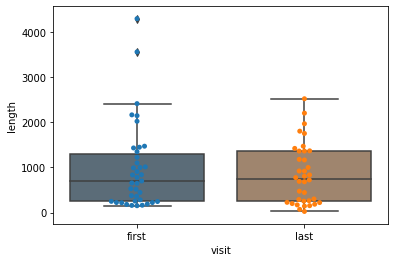

In [43]:
import seaborn as sns
sns.boxplot(x = 'visit' , y = 'length', data = length_df
           , saturation = 0.2)
sns.swarmplot(x = 'visit' , y = 'length', data = length_df)
# x = np.random.normal(1, 0.04, size=len(y))
# plt.boxplot(y)
# plt.plot(x, y, 'r.', alpha=0.2)

In [52]:
n= []
for name, df in subset.groupby('fullname'):
    l = len(df)
    if l < 120:
        print(l)
        n.append(name)
print(n)        

71
24
['L0.1_c-3_m20_last', 'L0.1_c-3_m46_last']


# set the length of chuck and do the rest of analysis

In [108]:
# alternatively each chunck can be 40 frames == @100fps and @25Hz WBF is about 10 wingbeats
lengthOfEachChunk = 40
# lengthOfEachChunk = ShortestVideo
# lengthOfEachChunk = 40*3

# print out the tracks

In [109]:
# plot the tracks

def PlotTracks(x, y, ax):
    ax.plot(x,y, c= "k")
    ax.set_xlim(0, 648)
    ax.set_ylim(0, 488)
#     ax.set_ylabel("Y Position")
#     ax.set_xlabel("X Position")
    ax.grid(False)
    ax.axis('off')
#     pl.savefig(fig_path + "\\test3.png")

In [110]:
# make file folder to keep all track image
mystr = r"G:/My Drive/Mahad/Light Level Experiments/Data Output from Analysis/" \
                      r"motionAnalysis_Final/FractalDimension/Tracks/" 
filefolder = mystr + str(lengthOfEachChunk) + 'Frames/'
try:  
    os.mkdir(filefolder)  
except OSError as error:  
    print(error) 

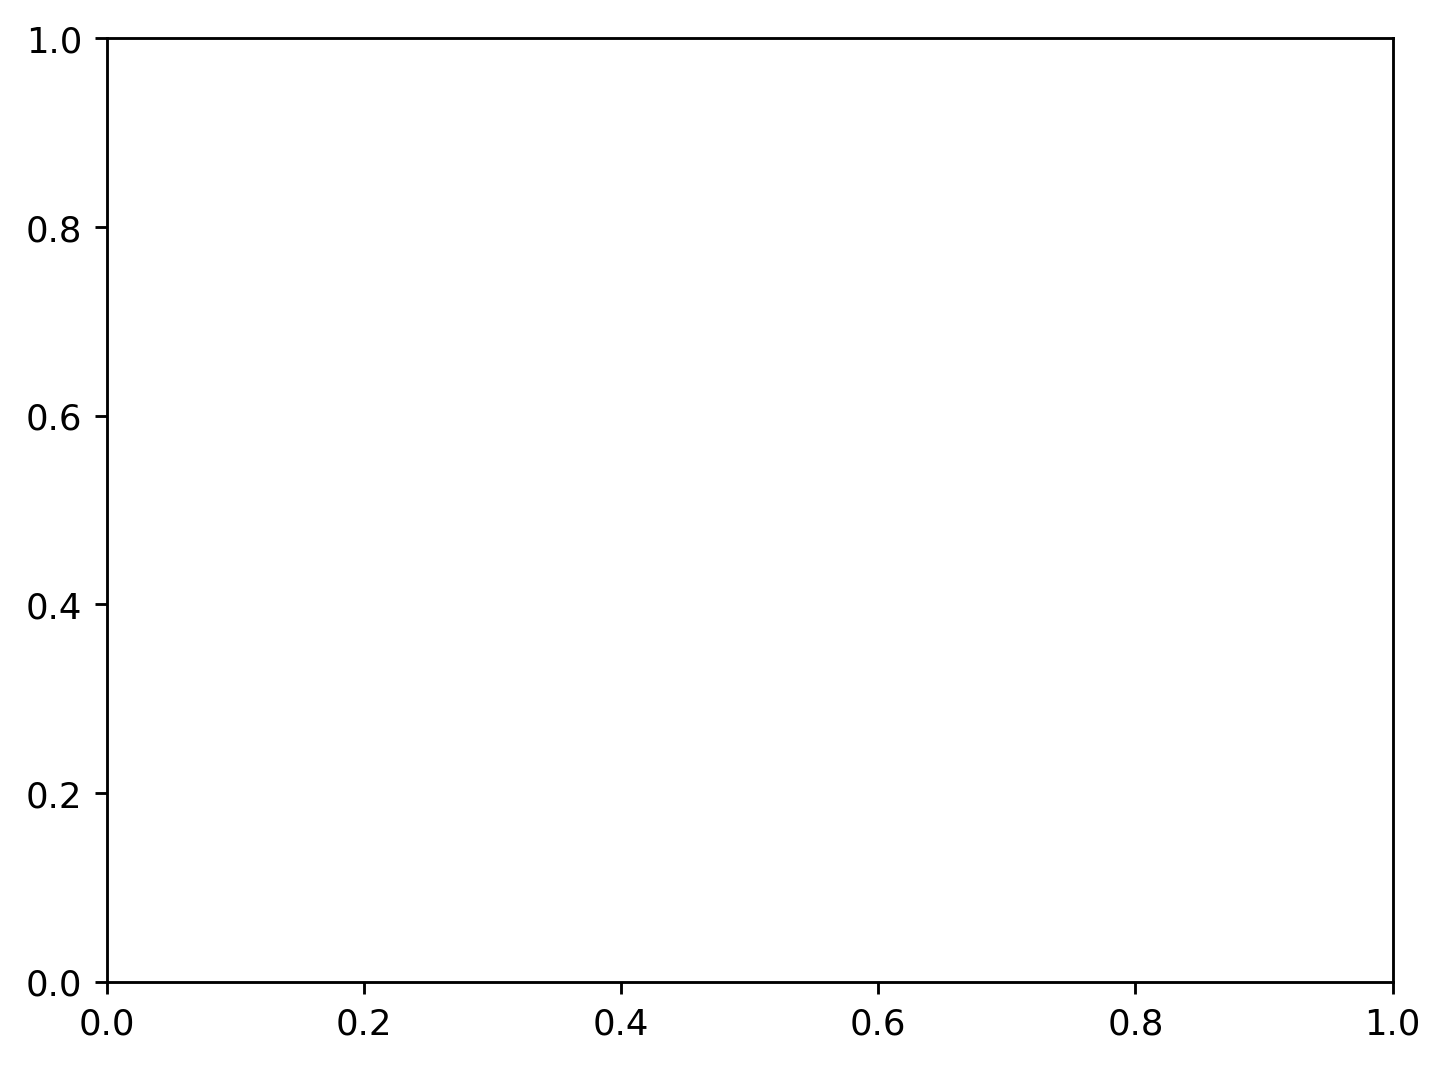

In [111]:
f, ax = plt.subplots(figsize = (648*1/100,488*1/100),  dpi= 256)
  
for name, df in data.groupby('fullname'):
    x = df.x_smoothened
    y = df.y_smoothened
    
    PlotTracks(x,y, ax)
    f.savefig(mystr + name + '.png')
    ax.cla()
    
    chunks = len(x)/lengthOfEachChunk
    
    for ii in np.arange(math.ceil(chunks)):
        ii = int(ii)
        if lengthOfEachChunk*ii + lengthOfEachChunk > len(x):
            x_section = x[-lengthOfEachChunk:]
            y_Section = y[-lengthOfEachChunk:]
#             continue
        else:
            x_section = x[lengthOfEachChunk*ii : lengthOfEachChunk*ii + lengthOfEachChunk]
            y_section = y[lengthOfEachChunk*ii : lengthOfEachChunk*ii + lengthOfEachChunk]
            
            PlotTracks(x_section, y_section, ax)
            figname = name+'_chunk'+str(ii)
            f.savefig(filefolder  + figname + '.png')
            ax.cla()

# read in the track chunks and do the box dimension analysis

In [112]:
# lengthOfEachChunk = ShortestVideo
# lengthOfEachChunk = 40*3
lengthOfEachChunk = 40
filefolder = mystr + str(lengthOfEachChunk) + 'Frames/'

In [113]:
from numpy.polynomial.polynomial import polyfit

def boxDimension(x,y):
    highest_power = 7 
    scale = np.logspace(2, highest_power, num = highest_power-1, base = 2)
    number_filled = []
    dimension_list = []

    for b in scale:
        bins = b
        heatmap, xedges, yedges = np.histogram2d(-y, x, bins=int(bins))
        box_num = heatmap[heatmap > 0]
        number_filled.append(float(len(box_num)))

    number_filled = np.asarray(number_filled)
    b, m = polyfit((np.log(scale)/np.log(2)), (np.log(number_filled)/np.log(2)), 1) 
    dimension_list.append(m)
    dimension = np.mean(dimension_list)
    
    return(dimension)

In [114]:
def convertImage2BoxDim(im):
    im = (im < 255) * 100
    image = cv2.cvtColor(im.astype("uint8"), cv2.COLOR_BGR2GRAY)
    x = np.where(image > 0)[1]
    y = np.where(image > 0)[0]

    d = boxDimension(x,y)
    return(d)

In [115]:
files = glob.glob(filefolder + '*chunk*.png')
if not files:
    print('No files were read')
else:
    print('%d files were read' %len(files))

2357 files were read


In [127]:
# do this for the entire tracks

filefolder = mystr

files = glob.glob(filefolder + '*L*.png')
if not files:
    print('No files were read')
else:
    print('%d files were read' %len(files))

110 files were read


In [135]:
name = []
chunk = []
dimension = []

for i,f in enumerate(files): 
#     a,b,c,d, e = os.path.basename(f).split('_')
    a,b,c,d = os.path.basename(f).split('_')
    n = a + '_' + b + '_' + c + '_' + d[:-4]
#     part = e[:-4]
    part = 'whole'
    
    im = cv2.imread(f)
    
    dim = convertImage2BoxDim(im)
    
    name.append(n)
    chunk.append(part)
    dimension.append(dim)

C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [136]:
df = pd.DataFrame({'name' : name,
             'chunk' : chunk,
             'dimension' : dimension})
df.head()

,name,chunk,dimension
0,L0.1_c-3_m10_first,whole,1.574421
1,L0.1_c-3_m10_last,whole,1.240522
2,L0.1_c-3_m12_first,whole,1.583390
3,L0.1_c-3_m12_last,whole,1.235514
4,L0.1_c-3_m20_first,whole,1.402361


In [137]:
# remove the problematic moths - 

prob_cases = pd.read_csv(r"G:/My Drive/Mahad/Light Level Experiments/Data Output from Analysis/" \
                         r"VideosWithMarkers/FirstLastTroubleVideos_v4/names.csv")

prob_cases['name'] = prob_cases['name'].str[1:-9]
prob_cases.head()

,Unnamed: 0,name
0,0,L0.1_c-3_m10_first
1,1,L0.1_c-3_m10_last
2,2,L0.1_c-3_m12_first
3,3,L0.1_c-3_m12_last
4,4,L0.1_c-3_m23_last


In [138]:
df = df[~df['name'].isin(prob_cases.name)]

In [139]:
name = []
dimension = []
for n, sub in df.groupby('name'):
        mean_d = sub.dimension.mean()
        name.append(n)
        dimension.append(mean_d)  
final_dim = pd.DataFrame({'name' : name,
                         'dimension' : dimension})       

In [140]:
final_dim[['lightLevel', 'mothID']] = final_dim.name.str.split('_', n = 1, expand = True)
final_dim[['flower', 'mothID', 'visit']] = final_dim.mothID.str.split('_', n= 2, expand = True)
final_dim.to_csv(mystr + 'dimension_df_ChunkSize' + str(lengthOfEachChunk) + '.csv')
final_dim.head()

,name,dimension,lightLevel,mothID,flower,visit
0,L0.1_c-3_m20_first,1.402361,L0.1,m20,c-3,first
1,L0.1_c-3_m20_last,1.360398,L0.1,m20,c-3,last
2,L0.1_c-3_m21_first,1.555929,L0.1,m21,c-3,first
3,L0.1_c-3_m21_last,1.466146,L0.1,m21,c-3,last
4,L0.1_c-3_m22_first,1.413836,L0.1,m22,c-3,first


In [141]:
from scipy import stats
low_first = final_dim.loc[(final_dim.lightLevel == 'L0.1') & (final_dim.visit == 'first')
                          , 'dimension'].values
high_first = final_dim.loc[(final_dim.lightLevel == 'L0.1') & (final_dim.visit == 'first')
                           , 'dimension'].values
low_last = final_dim.loc[(final_dim.lightLevel == 'L0.1') & (final_dim.visit == 'last')
                          , 'dimension'].values
high_last = final_dim.loc[(final_dim.lightLevel == 'L50') & (final_dim.visit == 'last')
                          , 'dimension'].values

s_first, p_first = stats.mannwhitneyu(low_first, high_first)
print('mann Whitney U test: statistic %5f and p value %5f' %(s_first, p_first))

print(stats.ks_2samp(low_first, high_first))

s_last, p_last = stats.mannwhitneyu(low_last, high_last)
print('mann Whitney U test: statistic %5f and p value %5f' %(s_last, p_last))

print(stats.ks_2samp(low_last, high_last))

p = [p_first, p_last]

mann Whitney U test: statistic 220.500000 and p value 0.494978
Ks_2sampResult(statistic=0.0, pvalue=1.0)
mann Whitney U test: statistic 134.000000 and p value 0.192133
Ks_2sampResult(statistic=0.2777777777777778, pvalue=0.5025900605581054)


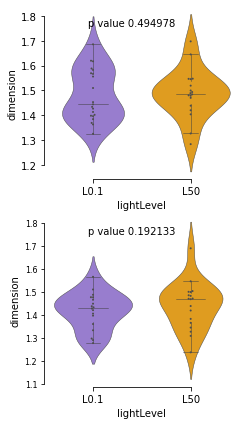

In [143]:
## make the plot
import seaborn as sns

f, ax = plt.subplots(2,1, figsize=(3.5, 3.5*2))
ax = ax.ravel()
i = 0
for visit, bla in final_dim.groupby('visit'):
    
    sns.violinplot(x="lightLevel", y="dimension", 
                   data = bla, 
                   inner = None,
                   linewidth = 0.5,
                   palette = ['mediumpurple','orange'],
                  ax = ax[i])

    sns.boxplot(x="lightLevel", y="dimension", 
                data = bla,
                linewidth = 0.5,
                fliersize = 0,
                width = 0.3,
               ax = ax[i])

    sns.swarmplot(x='lightLevel', y='dimension', 
                  data = bla,
                    size=2, 
                      color="0.3",
                      linewidth=0,
                 ax= ax[i])
    # print the p value into the plot
    ax[i].text(0.45, 0.90, 'p value %5f' %p[i], horizontalalignment='center',
        verticalalignment='center', transform=ax[i].transAxes)
#     ax[i].set_ylabel()
#     ax[i].set_xlabel()
    
    i+=1

# ax[1].text(0.45, 0.01, "Light level", size = 8, 
#           horizontalalignment='center',
#         verticalalignment='center', transform=ax[1].transAxes)
# ax[1].text(0.01, 1.5, "Box Dimension", size = 8, 
#           horizontalalignment='center',
#         verticalalignment='center',
#            rotation = 90,
#            transform=ax[1].transAxes)

# ax[0].set_xticklabels([], size = 8)
# ax[1].set_xticklabels(["Low","High"], size = 8)

sns.despine(trim=True)

for tick in ax[1].get_yticklabels():
    tick.set_fontsize(8) 
# ax.xaxis.grid(False)

# plt.savefig(mystr + 'BoxDimension_chunk' + str(lengthOfEachChunk) + ".pdf")
plt.savefig(mystr + 'BoxDimension_wholeTrack.pdf')

# do this analysis for not chunked Data

In [125]:
filefolder = mystr

In [126]:
files = glob.glob(filefolder + '*L*.png')
if not files:
    print('No files were read')
else:
    print('%d files were read' %len(files))

110 files were read
